Assignment 5 - EP20BTECH11004

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Part 1 - Optimal Decorrelating Transform

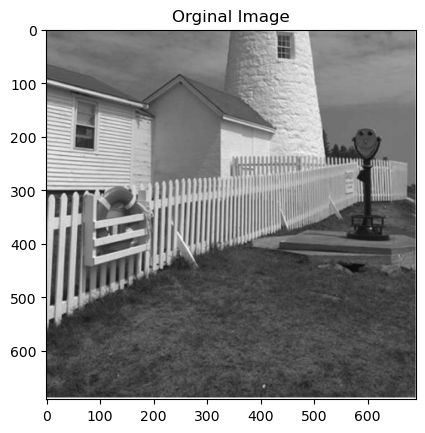

(691, 691)


In [2]:
folder = './figs/'
filenames = ['lighthouse.png', 'first_frame.png', 'second_frame.png']
files = [folder + file for file in filenames]

I = np.asarray(Image.open(files[0]).convert('L')).astype(int)
plt.imshow(I, cmap = 'gray')
plt.title('Orginal Image')
plt.show()
print(I.shape)

Q1

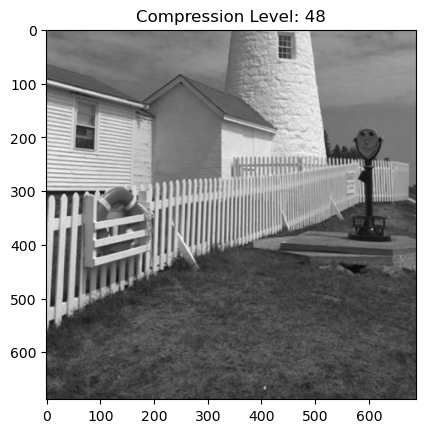

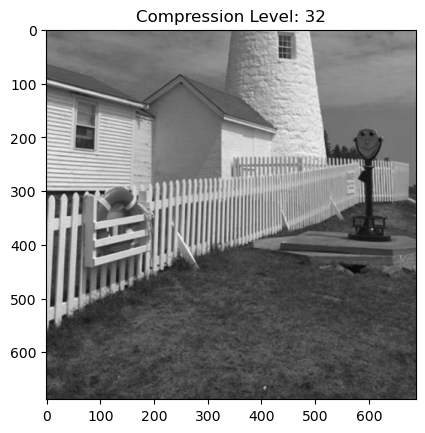

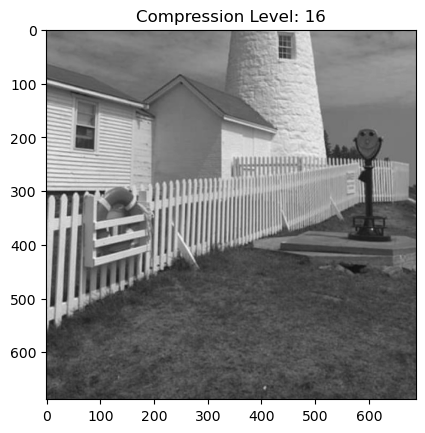

In [3]:
img = I[:688, :688]                             #multiple of 16
samples = np.empty((64, 0))

M, N = img.shape
for i in range(0, M, 8):
    for j in range(0, N, 8):
        vector = np.reshape(img[i : i + 8, j : j + 8], (64, 1))
        samples = np.append(samples, vector, axis = 1)

mean = np.mean(samples, axis = 1)
samples = samples - np.outer(mean, np.ones(7396))

cov = (1/7396) * np.matmul(samples, samples.T)

eig_Val, eig_Vec = np.linalg.eig(cov)

idx = eig_Val.argsort()[::-1]   
eigVal = eig_Val[idx]
eigVec = eig_Vec[:, idx]

for comp in [48, 32, 16]:
    eigVec_t = eigVec[:, :comp]

    res = np.matmul(eigVec_t, np.matmul(eigVec_t.T, samples))
    res = res + np.outer(mean, np.ones(7396))

    M, N = np.shape(img)
    out = np.zeros((M, N))
    for i in range(0, M, 8):
        for j in range(0, N, 8):
            out[i: i + 8, j: j + 8] = np.reshape(res[:, 86 * (i//8) + (j//8)], (8, 8))
        
    plt.imshow(out, cmap = 'gray')
    plt.title(f'Compression Level: {comp}')
    plt.show()

Yes, PCA is effective in decorrelating images. Even with using a fourth of the total eigenvectors we can almost perfectly reconstruct the image. 

Part 2 - Discrete Cosine Transform

In [4]:
def DCT(mat):
    M, N = mat.shape
    out = np.zeros((M, N))
    for u in range(M):
        for v in range(N):
            C_u = 1
            C_v = 1
            if u == 0:
                C_u = 1/np.sqrt(2)
            if v == 0:
                C_v = 1/np.sqrt(2)
            for i in range(M):
                for j in range(N):
                    out[u, v] += (4 * C_u * C_v/(M * N)) * mat[i, j] * np.cos((2 * i + 1) * u * np.pi/(2 * M)) * np.cos((2 * j + 1) * v * np.pi/(2 * N))
    return out

def IDCT(mat):
    M, N = mat.shape
    out = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            for u in range(M):
                for v in range(N):
                    C_u = 1
                    C_v = 1
                    if u == 0:
                        C_u = 1/np.sqrt(2)
                    if v == 0:
                        C_v = 1/np.sqrt(2)
                    out[i, j] += C_u * C_v * mat[u, v] * np.cos((2 * i + 1) * u * np.pi/(2 * M)) * np.cos((2 * j + 1) * v * np.pi/(2 * N))
    return out

In [5]:
Q = np.array([[16, 11, 10, 16,  24,  40,  51,  61],
              [12, 12, 14, 19,  26,  58,  60,  55],
              [14, 13, 16, 24,  40,  57,  69,  56],
              [14, 17, 22, 29,  51,  87,  80,  62],
              [18, 22, 37, 56,  68, 109, 103,  77],
              [24, 35, 55, 64,  81, 104, 113,  92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103,  99]])

def quant(block):    
    out = np.zeros((8, 8), dtype = int)
    for i in range(8):
        for j in range(8):
            out[i, j] = round(block[i, j] / Q[i, j])    
    return out

def inv_quant(block):  
    out = np.zeros((8, 8), dtype = int)
    for i in range(8):
        for j in range(8):
            out[i, j] = int(block[i,j] * Q[i,j])
    return out

Encoder:

In [6]:
def enc(img):
    M, N = img.shape
    out = np.zeros((M, N))
    num_zeros = 0
    
    for i in range(0, M, 8):
        for j in range(0, N, 8):
            block = img[i: i + 8, j: j + 8]               #Q1
            DCT_block = DCT(block)                        #Q2
            dct_block = quant(DCT_block)                  #Q3

            for m in range(8):
                for n in range(8):
                    if dct_block[m, n] == 0:
                        num_zeros += 1
            
            out[i : i + 8, j : j + 8] = dct_block
    
    return out, num_zeros/((M * N)/64)

Q3: Verify that it is sparse

In [7]:
enc_img, avg_zeros = enc(img)
print(avg_zeros)

60.988236884802596


The value of avg_zeros is high, verifying that ezch of the quantized 8 x 8 DCT blocks are sparse.

Decoder:

In [8]:
def dec(dct_mat):
    M, N = np.shape(dct_mat)
    out = np.zeros((M, N))
    
    for i in range(0, M, 8):
        for j in range(0, N, 8):
            dct_block = dct_mat[i: i + 8, j: j + 8]         
            DCT_block = inv_quant(dct_block)                #Q1
            block = IDCT(DCT_block)                         #Q2

            out[i: i + 8, j: j + 8] = block                 #Q3
    return out

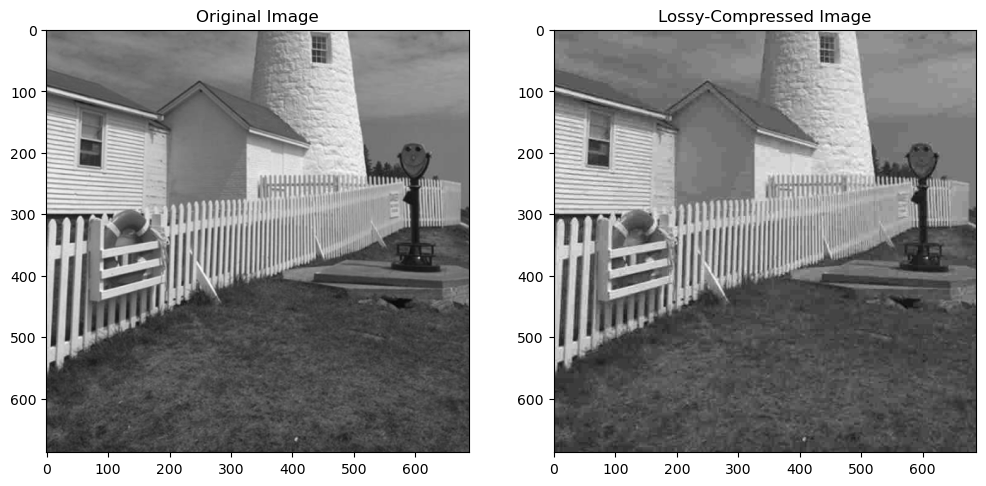

In [9]:
img_out = dec(enc_img)

fig, axs = plt.subplots(1, 2, figsize = (12,6))
axs[0].imshow(img, cmap = 'gray')
axs[0].set_title('Original Image')
axs[1].imshow(img_out, cmap = 'gray')
axs[1].set_title('Lossy-Compressed Image')
plt.show()

The decompressed image is not as good as the orginal, i.e, there is some information loss. However it is still an effective method.

Part 3 - Motion Estimation

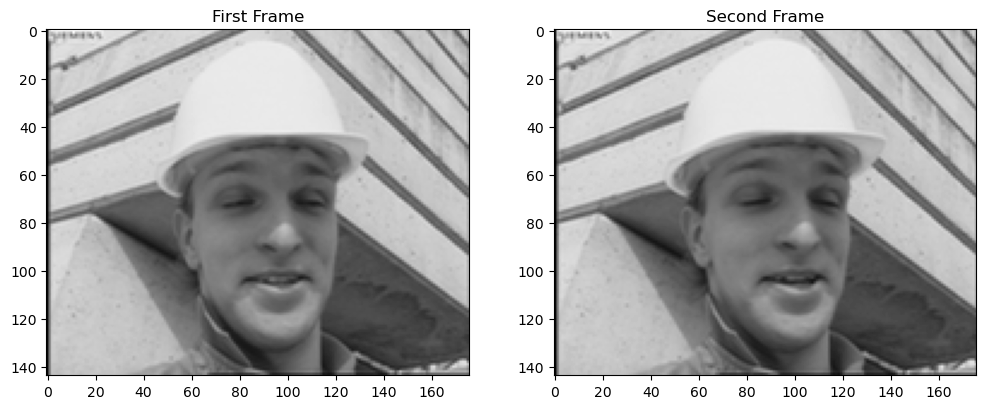

In [10]:
frame1 = np.asarray(Image.open(files[1]).convert('L')).astype(int)
frame2 = np.asarray(Image.open(files[2]).convert('L')).astype(int)

fig, axs = plt.subplots(1, 2, figsize = (12,6))
axs[0].imshow(frame1, cmap = 'gray')
axs[0].set_title('First Frame')
axs[1].imshow(frame2, cmap = 'gray')
axs[1].set_title('Second Frame')
plt.show()

Q1

In [11]:
def MAD(I, J):
    out = 0
    M, N = np.shape(I)
    for m in range(M):
        for n in range(N):
            out += abs(I[m, n] - J[m, n])
    
    return out/(M * N)

M, N = frame1.shape
motion_vec = np.zeros((int(M/16), int(N/16), 2)).astype('int')

for i in range(int(M/16)):
    for j in range(int(N/16)):        
        d1, d2 = 0, 0
        macroblock = frame2[16 * i : 16 * (i + 1), 16 * j : 16 * (j + 1)]
        
        for k in [4, 2, 1]:
            x, y = 16 * i + d1, 16 * j + d2        
            error = np.inf            
            dist = k * np.arange(-1, 2)
            for a in dist:
                for b in dist:
                    if x + a >= 0 and x + a + 15 < M and y + b >= 0 and y + b + 15 < N:
                        mad = MAD(frame1[x + a: x + a + 16, y + b : y + b + 16], macroblock)
                        if mad < error:
                            error = mad
                            b1, b2 = a, b
                            
            d1 += b1
            d2 += b2
               
        motion_vec[i, j, :] = np.array((d1, d2))

Q2

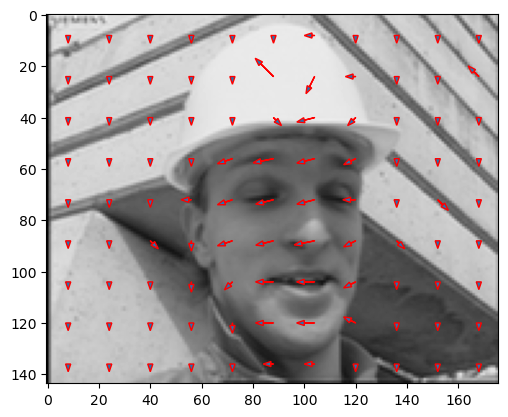

In [12]:
vector_plot = plt.imshow(frame2, cmap = 'gray')

for i in range(int(M/16)):
    for j in range(int(N/16)):
        plt.arrow(16 * j + 8, 16 * i + 8, motion_vec[i, j , 1], motion_vec[i , j , 0], head_width = 2, width = 0.05, ec = "red")
plt.show()

Q3

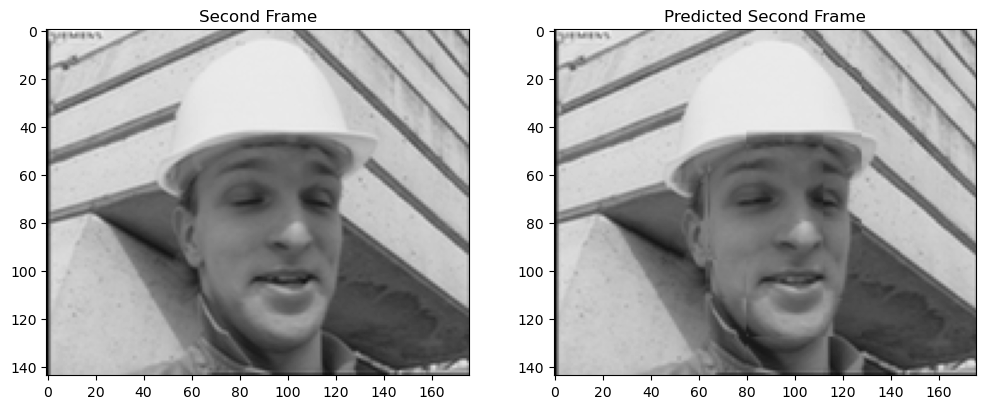

In [13]:
pred_img = np.zeros(frame1.shape)

for i in range(int(M/16)):
    for j in range(int(N/16)):
        pred_img[16 * i : 16 * (i + 1), 16 * j : 16 * (j + 1)] = frame1[16 * i + motion_vec[i, j, 0] : 16 * (i + 1) + motion_vec[i, j, 0], 16 * j + motion_vec[i, j, 1] : 16 * (j + 1) + motion_vec[i, j, 1]]

fig, axs = plt.subplots(1, 2, figsize = (12,6))
axs[0].imshow(frame2, cmap = 'gray')
axs[0].set_title('Second Frame')
axs[1].imshow(pred_img, cmap = 'gray')
axs[1].set_title('Predicted Second Frame')
plt.show()

Q4

Error b/w orginal and predicted second frame: 2.956912878787879


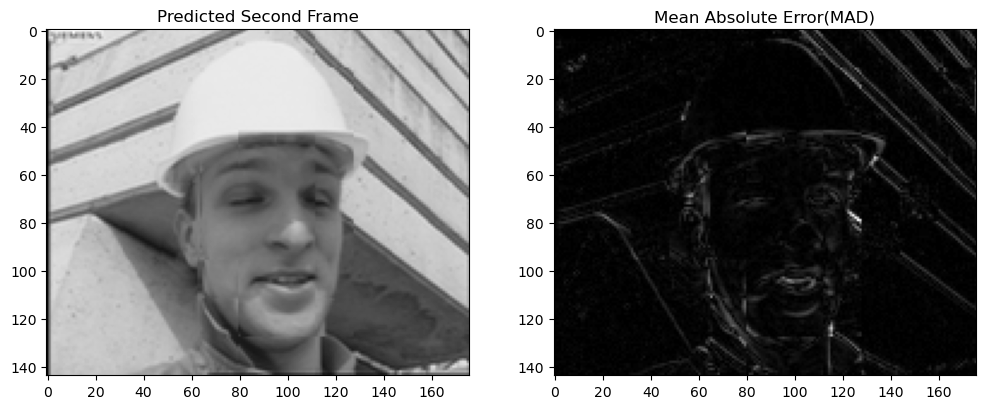

In [14]:
print(f'Error b/w orginal and predicted second frame: {MAD(frame2, pred_img)}')

fig, axs = plt.subplots(1, 2, figsize = (12,6))
axs[0].imshow(pred_img, cmap = 'gray')
axs[0].set_title('Predicted Second Frame')
axs[1].imshow(np.abs(frame2 - pred_img), cmap = 'gray')
axs[1].set_title('Mean Absolute Error(MAD)')
plt.show()